In [1]:
# %conda install -c conda-forge ta-lib -q
# %pip install -r requirements.txt -q

import boto3
import data
import glob
import matplotlib.pyplot as plt
import models
import numpy as np
import os
import pandas as pd
import pypickle
import strategy

from data import * 
from feature_engineering import create_features, normalize_features
from io import StringIO
from IPython.display import display
from sklearn.linear_model import LassoCV
from utils import log

2025-02-16 08:51:51.239490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739695911.273952    3102 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739695911.281033    3102 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 08:51:51.304901: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system ha

# Read

The data of the selected pairs to trade.

In [2]:
# Define S3 bucket and file path
bucket_name = 'mscfe-capstone-project-bucket'
file_key = 'filtered_data.csv'

# Initialize S3 client
s3 = boto3.client('s3')

# # Read the CSV file from S3
# obj = s3.get_object(Bucket=bucket_name, Key=file_key)
# filtered = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8'))).drop(['Unnamed: 0'], axis=1)
filtered = pd.read_csv('filtered_data.csv').drop(['Unnamed: 0'], axis=1)

display(filtered)

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
0,GOOG,GOOGL,0.999931,-4.971937,0.000025,True,-4.976339,0.000182,True
1,META,DAXEX_ETF,0.888934,-2.917056,0.043400,True,-3.483091,0.033924,True
2,AMZN,BNBUSDT,0.877059,-3.631203,0.005192,True,-3.545100,0.028601,True
3,AMZN,TRXUSDT,0.814577,-3.869803,0.002269,True,-3.387413,0.043768,True
4,SPY_ETF,AVAXUSDT,0.847292,-3.309927,0.014441,True,-3.698512,0.018406,True
5,SPY_ETF,ETHUSDT,0.862483,-3.428205,0.010034,True,-3.737367,0.016394,True
6,EQQQ_ETF,BNBUSDT,0.886060,-3.816404,0.002744,True,-3.670509,0.019987,True
7,BNBUSDT,ADAUSDT,0.901459,-3.279504,0.015820,True,-3.775562,0.014607,True
8,BNBUSDT,BTCUSDT,0.884604,-2.909961,0.044202,True,-3.393160,0.043116,True
9,BNBUSDT,TRXUSDT,0.933562,-3.656380,0.004770,True,-4.003675,0.007095,True


We have the following pairs to trade:
- GOOG and GOOGL: Google Series A and Google Series C - since both securities depict the performance of the same company, we do not want to consider this pair in our portfolio
- META and DAX ETF
- AMZN and BNBUSDT: Amazon and Binance Coin
- AMZN and TRXUSDT: Amazon and TRON cryptocurrency
- S&P 500 ETF and AVAXUDST: S&P 500 ETF and Avalanche cryptocurrency
- S&P 500 ETF and ETHUDST: S&P 500 ETF and Ethereum cryptocurrency
- EQQQ ETF and BNBUSDT: Nasdaq 100 ETF and Binance coin cryptocurrency
- BNBUSDT and ADAUSDT: Binance Coin and Cardano cryptocurrency
- BNBUSDT and BTCUDST: Binance Coin and Bitcoin
- BNBUSDT and TRXUDST: Binance Coin and TRON cryptocurrency
- BNBUSDT and XRPUDST: Binance Coin and XRP (Ripple) cryptocurrency.

As we can see, the portfolio is composed mostly of cryptocurrencies, but there is also an equity pair (Meta/DAX ETF) as well as equity-cryptocurrency pairs: S&P 500 ETF/Avalanche and S&P 500 ETF/Ethereum. Such a composition, in hindsight, should not come as a surprise because:
- **Cryptocurrency pairs** are driven by similar factors and in this market events on all tradeable coins are still mostly driven by Bitcoin, hence high correlations and time-invariant spreads are fairly expected
- **Equity-cryptocurrency pairs**: S&P 500 ETF against Avalanche and Ethereum reflect the increasing interest in and integration of the traditional financial markets and digital assets, while Amazon against Binance coin and TRON may capture the relationship between large-cap technology firms and the broader crypto ecosystem - AWS is widely used in the blockchain infrastructure and Binance Coin is tied to one of the largest cryptocurrency exchanges
- The **equity-equity pair** Meta/DAX ETF suggests a potential macroeconomic link: Meta is a global tech giant while DAX represents the broader European market; hence these two correlating may be drien by similar trends and/or risk sentiments.

In [3]:
print('********************')
pairs = filtered['seriesX'].iloc[1:] + ' ' + filtered['seriesY'].iloc[1:]
print('Trading pairs:')
for p in pairs:
    print(p)
print('********************')

unique_tickers = pd.concat([filtered['seriesX'].iloc[1:], filtered['seriesY'].iloc[1:]]).drop_duplicates()
print('Unique tickers:')
for ut in unique_tickers:
    print(ut)
print('********************')

# Preview the source data
file_key = 'df_full.csv'
# df_full = pd.read_csv('df_full.csv').drop(['Unnamed: 0'], axis=1)
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
df_full = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8'))).drop(['Unnamed: 0'], axis=1)
display(df_full.sample(5))

********************
Trading pairs:
META DAXEX_ETF
AMZN BNBUSDT
AMZN TRXUSDT
SPY_ETF AVAXUSDT
SPY_ETF ETHUSDT
EQQQ_ETF BNBUSDT
BNBUSDT ADAUSDT
BNBUSDT BTCUSDT
BNBUSDT TRXUSDT
BNBUSDT XRPUSDT
********************
Unique tickers:
META
AMZN
SPY_ETF
EQQQ_ETF
BNBUSDT
DAXEX_ETF
TRXUSDT
AVAXUSDT
ETHUSDT
ADAUSDT
BTCUSDT
XRPUSDT
********************


,OpenTime,Open,High,Low,Close,Symbol
214984,2024-11-20 02:45:00,0.39361,0.39398,0.3920,0.39231,DOGEUSDT
58921,2024-12-19 18:00:00,588.14500,588.40000,587.7600,588.13000,SPY_ETF
309235,2024-12-22 20:10:00,3349.52000,3361.56000,3348.6900,3355.30000,ETHUSDT
57610,2024-12-18 18:25:00,594.90000,595.02000,592.9200,593.27000,SPY_ETF
269689,2024-12-09 02:35:00,2.40370,2.40840,2.4016,2.40560,XRPUSDT


## Prepare Spreads of the Final Pairs

Once we have the pairs series prepared and aligned in time, we can proceed with spread calculation. Spread between two assets at time $t$ is given directly as the difference between two asset prices, i.e., $$\text{Spread}_{AB, t} = p_{A,t} - p_{B, t}$$ where $p_A$ - price of asset A and $p_B$ - price of asset B.

The next step is to normalize the spread by subtracting the mean and dividing by standard deviation, given as $$\text{Normalized Spread}_t = \frac{\text{Spread}_{AB, t} - \mu_{\text{Spread}_{AB}}}{\sigma_{\text{Spread}_{AB}}}$$

In the base case scenario, a **trading signal** is identified when spread is below -2 or above 2 with the following interpretation:
- $\text{Spread}_{AB, t} < -2$: buy A, sell B
- $\text{Spread}_{AB, t} > 2$: buy B, sell A.

## Additional Considerations

Our trading strategy will work flawlessly if there is always a sequence of events:
1. *Signal* Buy 1 unit of asset A, sell 1 unit of asset B.
2. No action for $n$ periods.
3. *Signal* Sell 1 unit of asset A, buy 1 unit of asset B.

However, in reality, we cannot assume that such a scenario will always occur. Below we have listed some exceptions and how we have handled them:
- A sequence of consecutive trading signals in the next $k$ forecasts: due to the assumption of next-period-opening-price execution (we are unable to open a position at the same tick that feeds the forecast), we must consider the scenario in which we receive more than one trading signal in a row and how we manage the positions. The possibilities are as follows:
    - *First signal entry*: immediate reaction resulting in increasing our exposure on assets A and B until the exposure limit has been reached, which we discuss in the next point; ensures timely reaction to the forecast, but may lead to unnecessarily frequent trades and transaction costs;
    - *Last signal entry*: waiting until the sequence of trading signals is interrupted by a 'No action' forecast; reduces information noise but may execute trades at less favorable prices;
    - *Threshold-based confirmation*: entering a trade only after receiving $m$ trading subsequent signals, e.g., $m=3$; similarly to last signal entry, it helps avoid information noise, but may lead to less favorable execution; this approach 
- Risk management with respect to portfolio asset allocation: having up to 10 unique assets (assuming all trading pairs have generated signals within the same time frame), we must take certain measures to ensure diversification and avoid overexposure to a single asset by assuming that we limit the exposure to any single asset to **25%** of the total portfolio value.
- Trending spread instead of mean reversion: we can forcefully close the position if the spread does not generate an opposite trading signal within $X$ periods
- Conflicting trading signals: it is possible that while on the pair A-B there is a long/short signal, on the pair A-C there is a short/long signal and the position on A would net to 0. Such a situation can be observed in the Forex market and we are allowing it in this project.

# Benchmark Portfolio

Before we train the models of interest, we must first create a baseline portfolio. We have decided to use a simple buy-and-hold strategy, as frequently seen in academic literature and in the practitioners' approaches.

The benchmark buy and hold portfolio is composed of the equally weighted unique instruments, as listed above:
- META
- AMZN
- SPY_ETF
- EQQQ_ETF
- BNBUSDT
- DAXEX_ETF
- TRXUSDT
- AVAXUSDT
- ETHUSDT
- ADAUSDT
- BTCUSDT
- XRPUSDT.

Therefore, the portfolio return is given as $r_{BP} = \frac{1}{n}\sum_{i=1}^{n}r_i$ with $r_i = \frac{P_{T,i}-P_{1,i}}{P_{1,i}}$ – $i^{th}$ asset discrete return and $P_{t,i}$ – price of asset $i$ at time $t$, $n=12$ assets in the benchmark portfolio.

In [4]:
asset_returns = []

# Calculate each asset's return
for ticker in unique_tickers:
    sub_df = df_full[df_full['Symbol']==ticker].copy()
    sub_df['OpenTime'] = pd.to_datetime(sub_df['OpenTime'])
    sub_df= sub_df.set_index('OpenTime')
    sub_df = sub_df.sort_index()
    sub_df = sub_df['Close']
    p1 = sub_df.iloc[0]
    pT = sub_df.iloc[-1]
    r_i = (pT-p1)/p1*100
    asset_returns.append({'Symbol': ticker, 'P1': p1, 'PT': pT, 'Return':r_i})

benchmark_return = pd.DataFrame(asset_returns)
display(benchmark_return)
average_return = benchmark_return['Return'].mean()

# Annualize the return
number_of_days = (pd.to_datetime(df_full['OpenTime'].max())
                  - pd.to_datetime(df_full['OpenTime'].min())).days
annualized_return = (1+average_return/100)**(365/number_of_days) - 1

print(f'Benchmark buy-and-hold portfolio return: {round(average_return, 4)}%')
print(f'Annualized return: {round(annualized_return*100, 4)}%')

,Symbol,P1,PT,Return
0,META,593.1400,612.7700,3.309505
1,AMZN,189.0517,225.9400,19.512282
2,SPY_ETF,581.8000,597.4900,2.696803
3,EQQQ_ETF,37990.0000,42967.0000,13.100816
4,BNBUSDT,556.3000,697.9800,25.468273
5,DAXEX_ETF,162.5000,174.0200,7.089231
6,TRXUSDT,0.1566,0.2524,61.174968
7,AVAXUSDT,26.3200,39.0400,48.328267
8,ETHUSDT,2420.2100,3379.6100,39.641188
9,ADAUSDT,0.3521,0.9860,180.034081


Benchmark buy-and-hold portfolio return: 65.1035%
Annualized return: 453.1127%


The benchmark buy-and-hold portfolio in the training period from 04/10/2024 to 20/01/2025 (108 days) generates a return of 65.1035%. After annualizing we get a whopping return of 453.1127%. Such an outstanding portfolio performance is mostly attributed to the cryptocurrency components of our portfolio: BTCUSDT gained 55.48%, ADAUSDT gained 180.03% and XRPUSDT gained 325.40% over the training period However, it is crucial to remember that cryptocurrencies are highly volatile and while in some periods they can generate incredibly high returns, in other periods they can generate even higher losses. In the training period the most important reason for the price increases was the U. S. presidential election: a win by Donal Trump was welcomed enthusiastially in the markets (both cryptocurrency and conventional). Therefore, annualizing cryptocurrency returns bears high risk.

# Model Training

Each pair has its own model trained. First, the models are trained with default hyperparameters. As a next step, we will tune some of them. Given the fact that the objective of this project is not to explore models as such, but finding the optimal model for long/short pair trading portfolio, we shall not focus on all of the hyperparameters, especially for neural networks, known for the multitude of possibly tuneable parameters.

Additionally, we apply the standard 80:20 training-validation split, i.e., the first 80% of the full training set is used for training and the last 20% for validation and later for hyperparameter tuning. The timeline of the train-validation split is then: 04/10/2024 – 30/12/2024 – training set and 30/12/2024 – 20/01/2025 – validation set.

<u>**NOTE**</u> Currently the models add 5 lags of normalized spread to have some features for modeling.

The Technical Analysis features added are:
- EMA(8), EMA(21), EMA(55) - 8-, 21- and 55-period Exponential Moving Average
- MACD(12, 26, 9) – MACD with 12- and 26-period MAs and 9-period signal line
- RSI(14) – 14-period RSI
- BB(20, 2) – 20-period Bollinger Bands with 2 standard deviations
- ATR(14) – 14-period Average True Range
- Stochastic(14, 3, 3) – Stochastic oscillator with 14-period fast %K and 3-period slow %K and %D
- CCI(20) – 20-period Commodity Channel Index
- %R(14) – 14-period Williams %R oscillator.

,META_EMA8,META_EMA21,META_EMA55,META_MACD,META_RSI14,META_BBupper,META_BBmiddle,META_BBlower,META_ATR14,META_StochK14,...,DAXEX_ETF_BBupper,DAXEX_ETF_BBmiddle,DAXEX_ETF_BBlower,DAXEX_ETF_ATR14,DAXEX_ETF_StochK14,DAXEX_ETF_StochD3,DAXEX_ETF_CCI20,DAXEX_ETF_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-30 12:40:00,-0.112015,-0.252482,-0.531448,1.222947,1.690599,-0.262967,-0.234588,-0.198790,-0.459392,1.314240,...,-0.464160,-0.579344,-0.674906,1.140216,-1.478676,-1.436138,-1.803457,-1.397398,0.274508,No action
2024-10-30 12:45:00,-0.061112,-0.218091,-0.506947,1.347383,1.883822,-0.220207,-0.203277,-0.180259,-0.365947,1.314240,...,-0.454816,-0.602047,-0.726982,1.046290,-1.426290,-1.494198,-1.294698,-1.249917,0.359919,No action
2024-10-30 12:50:00,-0.023652,-0.187712,-0.483682,1.421145,1.809052,-0.183612,-0.175700,-0.162827,-0.559904,1.292751,...,-0.456761,-0.620966,-0.761320,1.149427,-1.277946,-1.425712,-0.917759,-0.954954,0.335966,No action
2024-10-30 12:55:00,-0.003625,-0.163879,-0.462794,1.429781,1.488510,-0.155382,-0.155089,-0.150716,-0.608739,1.297948,...,-0.462336,-0.637660,-0.788027,1.023118,-1.073270,-1.287395,-0.733970,-0.821181,0.281800,No action
2024-10-30 13:00:00,0.019626,-0.139024,-0.441350,1.446421,1.594570,-0.122025,-0.136847,-0.148741,-0.681066,1.261997,...,-0.473791,-0.654131,-0.808836,0.874105,-0.885385,-1.102847,-0.604544,-0.720969,0.318883,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.144e-01
  model = cd_fast.enet_coordinate_descent(


[pypickle] Pickle file loaded: [models/base_ridge_META_DAXEX_ETF.pkl]
Loaded Ridge Regression model from models/base_ridge_META_DAXEX_ETF.pkl.
Ridge Regression MSE: 0.0026686735800976863
[pypickle] Pickle file loaded: [models/base_xgb_META_DAXEX_ETF.pkl]
Loaded XGBoost model from models/base_xgb_META_DAXEX_ETF.pkl.
XGBoost MSE: 0.011973466746946252
[pypickle] Pickle file loaded: [models/base_lstm_META_DAXEX_ETF.pkl]


2025-02-16 08:51:58.000116: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Loaded LSTM model from models/base_lstm_META_DAXEX_ETF.pkl.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
LSTM MSE: 0.029251929073054527
[pypickle] Pickle file loaded: [models/base_rnn_META_DAXEX_ETF.pkl]
Loaded RNN model from models/base_rnn_META_DAXEX_ETF.pkl.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
RNN MSE: 0.02743150516615967
[pypickle] Pickle file loaded: [models/base_transformer_META_DAXEX_ETF.pkl]
Loaded Transformer model from models/base_transformer_META_DAXEX_ETF.pkl
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 
Transformer MSE: 0.0481820059810341


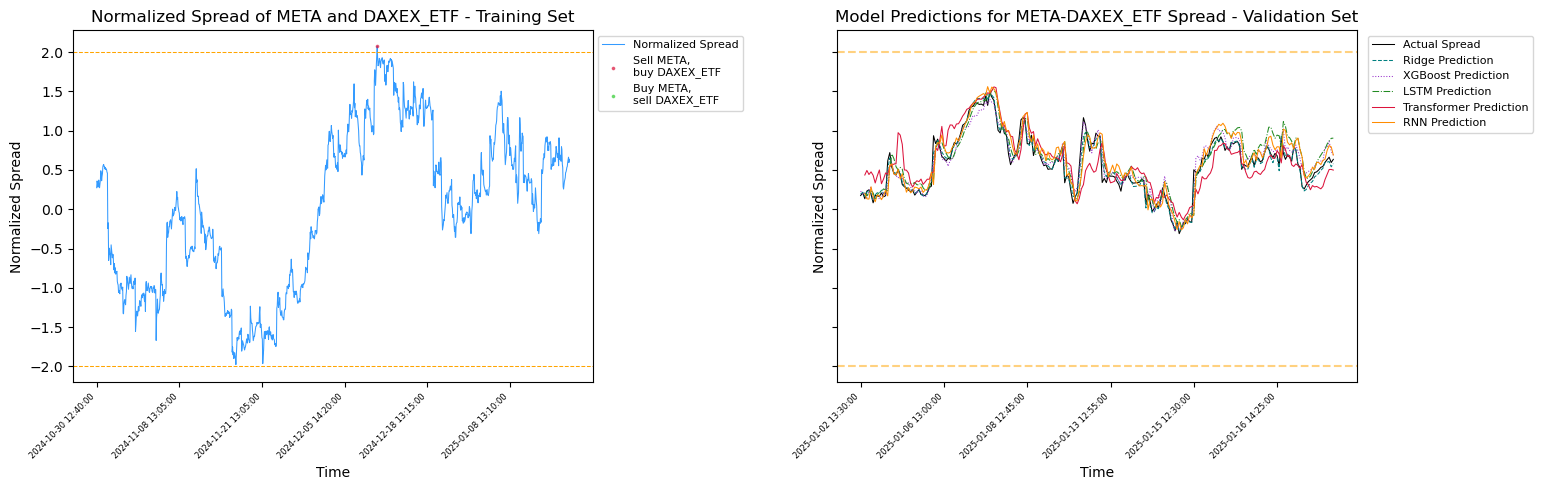

,AMZN_EMA8,AMZN_EMA21,AMZN_EMA55,AMZN_MACD,AMZN_RSI14,AMZN_BBupper,AMZN_BBmiddle,AMZN_BBlower,AMZN_ATR14,AMZN_StochK14,...,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,BNBUSDT_StochD3,BNBUSDT_CCI20,BNBUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-14 17:00:00,-1.391019,-1.376020,-1.345538,-0.474016,-1.382852,-1.406715,-1.372165,-1.329783,-1.308521,-1.394755,...,-1.090324,-1.054688,-1.002540,-0.464262,0.165367,-0.001501,1.034008,0.772447,0.820558,No action
2024-10-14 17:05:00,-1.393486,-1.378174,-1.347258,-0.484739,-1.308223,-1.408894,-1.374627,-1.332518,-1.365904,-1.500015,...,-1.087984,-1.053570,-1.002727,-0.495348,0.332386,0.171164,0.649071,0.462737,0.830704,No action
2024-10-14 17:10:00,-1.395551,-1.380194,-1.348941,-0.490461,-1.329398,-1.412758,-1.377320,-1.334014,-1.425862,-1.502413,...,-1.086201,-1.052173,-1.001755,-0.542537,0.555078,0.363014,0.456366,0.307882,0.835294,No action
2024-10-14 17:15:00,-1.395614,-1.381398,-1.350316,-0.473952,-0.918614,-1.418584,-1.379733,-1.332963,-1.418138,-1.276324,...,-1.085876,-1.051055,-0.999817,-0.549710,0.221040,0.382199,0.051695,-0.156683,0.852325,No action
2024-10-14 17:20:00,-1.397721,-1.383335,-1.351973,-0.479091,-1.242559,-1.421173,-1.381948,-1.334789,-1.387608,-1.315644,...,-1.086469,-1.049751,-0.996529,-0.593016,-0.196508,0.199942,-0.124791,-0.698676,0.853774,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.970e-01, tolerance: 4.441e-01
  model = cd_fast.enet_coordinate_descent(


[pypickle] Pickle file loaded: [models/base_ridge_AMZN_BNBUSDT.pkl]
Loaded Ridge Regression model from models/base_ridge_AMZN_BNBUSDT.pkl.
Ridge Regression MSE: 0.001169661810838656
[pypickle] Pickle file loaded: [models/base_xgb_AMZN_BNBUSDT.pkl]
Loaded XGBoost model from models/base_xgb_AMZN_BNBUSDT.pkl.
XGBoost MSE: 0.001934511616195603
[pypickle] Pickle file loaded: [models/base_lstm_AMZN_BNBUSDT.pkl]
Loaded LSTM model from models/base_lstm_AMZN_BNBUSDT.pkl.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
LSTM MSE: 0.0051847894659349785
[pypickle] Pickle file loaded: [models/base_rnn_AMZN_BNBUSDT.pkl]
Loaded RNN model from models/base_rnn_AMZN_BNBUSDT.pkl.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
RNN MSE: 0.0044657196208728565
[pypickle] Pickle file loaded: [models/base_transformer_AMZN_BNBUSDT.pkl]
Loaded Transformer model from models/base_transformer_AMZN_BNBUSDT.pkl
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Transformer MSE: 0.01914679023784512


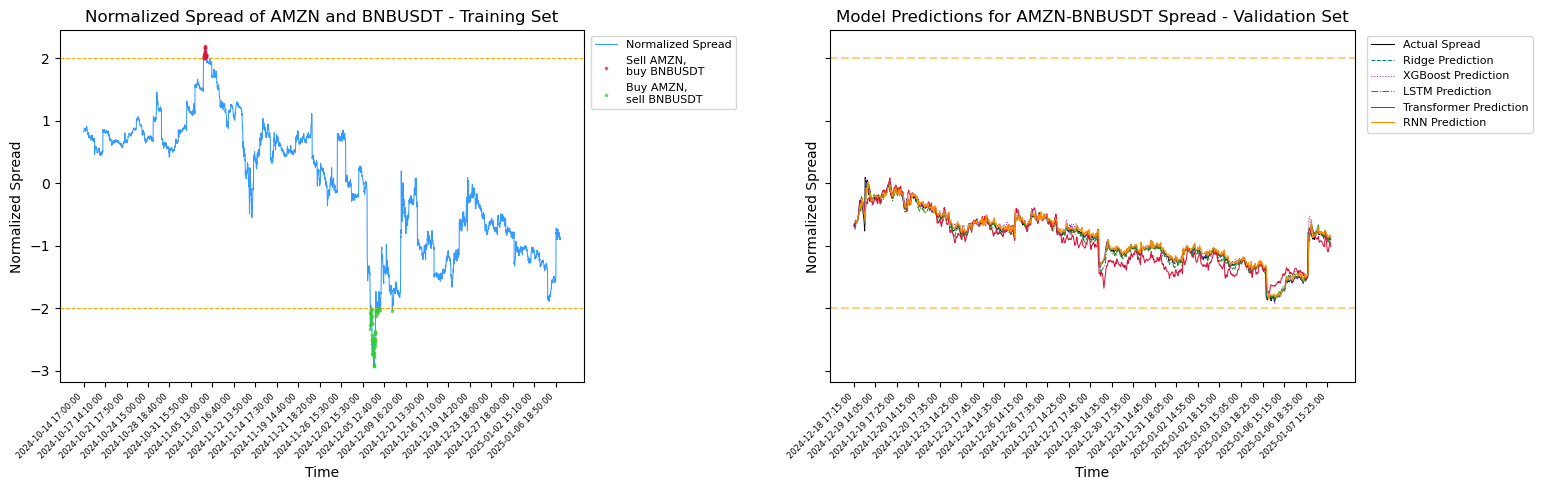

,AMZN_EMA8,AMZN_EMA21,AMZN_EMA55,AMZN_MACD,AMZN_RSI14,AMZN_BBupper,AMZN_BBmiddle,AMZN_BBlower,AMZN_ATR14,AMZN_StochK14,...,TRXUSDT_BBupper,TRXUSDT_BBmiddle,TRXUSDT_BBlower,TRXUSDT_ATR14,TRXUSDT_StochK14,TRXUSDT_StochD3,TRXUSDT_CCI20,TRXUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-14 17:00:00,-1.391019,-1.376020,-1.345538,-0.474016,-1.382852,-1.406715,-1.372165,-1.329783,-1.308521,-1.394755,...,-1.003805,-1.021299,-1.022773,-0.397742,-1.078408,-1.169139,-1.046867,-0.670369,-1.405124,No action
2024-10-14 17:05:00,-1.393486,-1.378174,-1.347258,-0.484739,-1.308223,-1.408894,-1.374627,-1.332518,-1.365904,-1.500015,...,-1.003900,-1.021656,-1.023419,-0.405184,-0.997874,-1.113696,-0.903442,-0.670369,-1.403799,No action
2024-10-14 17:10:00,-1.395551,-1.380194,-1.348941,-0.490461,-1.329398,-1.412758,-1.377320,-1.334014,-1.425862,-1.502413,...,-1.003704,-1.022192,-1.024765,-0.397448,-0.997874,-1.058254,-1.291489,-1.410546,-1.404448,No action
2024-10-14 17:15:00,-1.395614,-1.381398,-1.350316,-0.473952,-0.918614,-1.418584,-1.379733,-1.332963,-1.418138,-1.276324,...,-1.003698,-1.022728,-1.025901,-0.404911,-1.266321,-1.122937,-1.119873,-1.410546,-1.397489,No action
2024-10-14 17:20:00,-1.397721,-1.383335,-1.351973,-0.479091,-1.242559,-1.421173,-1.381948,-1.334789,-1.387608,-1.315644,...,-1.003844,-1.023265,-1.026865,-0.411841,-1.534767,-1.307744,-0.997136,-1.410546,-1.406768,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.479e-01, tolerance: 4.435e-01
  model = cd_fast.enet_coordinate_descent(


[pypickle] Pickle file loaded: [models/base_ridge_AMZN_TRXUSDT.pkl]
Loaded Ridge Regression model from models/base_ridge_AMZN_TRXUSDT.pkl.
Ridge Regression MSE: 0.0003695686698348647
[pypickle] Pickle file loaded: [models/base_xgb_AMZN_TRXUSDT.pkl]
Loaded XGBoost model from models/base_xgb_AMZN_TRXUSDT.pkl.
XGBoost MSE: 0.0037897158816597174
[pypickle] Pickle file loaded: [models/base_lstm_AMZN_TRXUSDT.pkl]
Loaded LSTM model from models/base_lstm_AMZN_TRXUSDT.pkl.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
LSTM MSE: 0.003414471364607391
[pypickle] Pickle file loaded: [models/base_rnn_AMZN_TRXUSDT.pkl]
Loaded RNN model from models/base_rnn_AMZN_TRXUSDT.pkl.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
RNN MSE: 0.00348682168028813
[pypickle] Pickle file loaded: [models/base_transformer_AMZN_TRXUSDT.pkl]
Loaded Transformer model from models/base_transformer_AMZN_TRXUSDT.pkl
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Transformer MSE: 0.011074728347945357


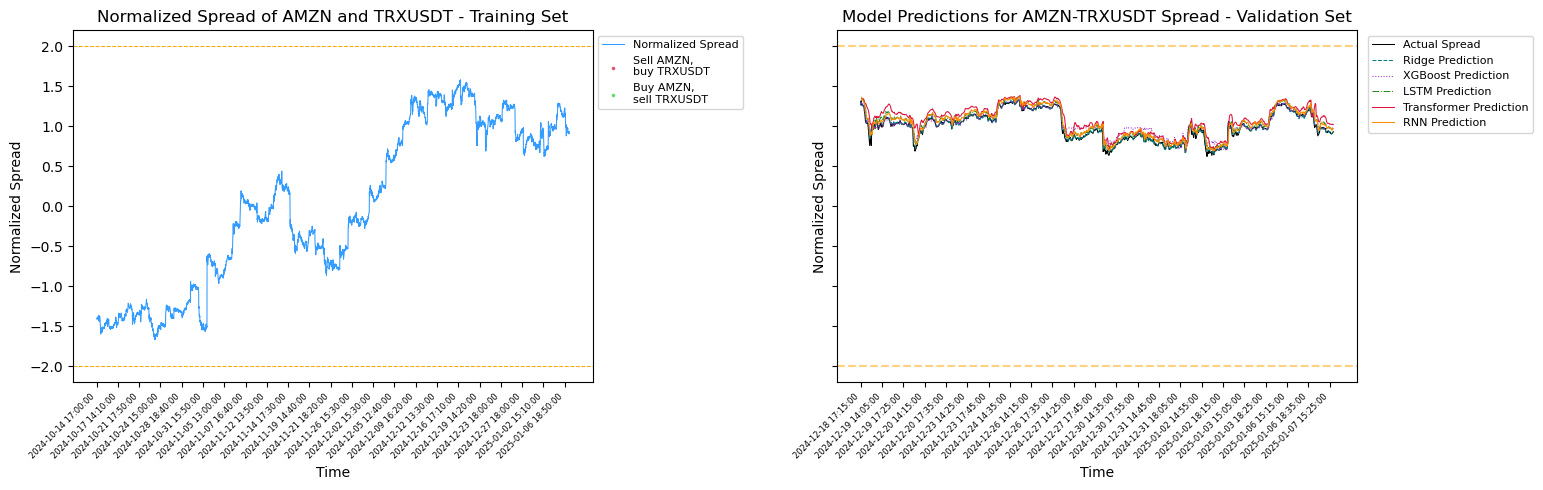

,SPY_ETF_EMA8,SPY_ETF_EMA21,SPY_ETF_EMA55,SPY_ETF_MACD,SPY_ETF_RSI14,SPY_ETF_BBupper,SPY_ETF_BBmiddle,SPY_ETF_BBlower,SPY_ETF_ATR14,SPY_ETF_StochK14,...,AVAXUSDT_BBupper,AVAXUSDT_BBmiddle,AVAXUSDT_BBlower,AVAXUSDT_ATR14,AVAXUSDT_StochK14,AVAXUSDT_StochD3,AVAXUSDT_CCI20,AVAXUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-14 17:00:00,-0.821943,-0.826815,-0.863946,0.095464,0.157968,-0.938772,-0.815009,-0.684807,-1.050478,-0.861277,...,-0.864934,-0.848104,-0.823769,-0.675312,0.288677,-0.143438,-0.098890,0.719066,-0.157526,No action
2024-10-14 17:05:00,-0.817547,-0.824756,-0.861979,0.112251,0.604617,-0.937313,-0.814156,-0.684547,-1.002269,-0.544443,...,-0.868481,-0.849438,-0.822746,-0.712623,0.530194,0.250854,-0.095807,0.622665,-0.111415,No action
2024-10-14 17:10:00,-0.813803,-0.822750,-0.860030,0.125837,0.632310,-0.935771,-0.813230,-0.684224,-1.051632,0.315535,...,-0.871775,-0.850716,-0.821878,-0.739345,0.633701,0.499552,-0.166764,0.429861,-0.104548,No action
2024-10-14 17:15:00,-0.807646,-0.819595,-0.857620,0.154405,0.901345,-0.932689,-0.812509,-0.685772,-1.036958,1.030674,...,-0.874108,-0.852217,-0.822485,-0.708691,0.219672,0.475807,-0.742714,-0.437753,-0.057456,No action
2024-10-14 17:20:00,-0.802424,-0.816548,-0.855227,0.177393,0.936069,-0.928929,-0.811485,-0.687382,-1.081603,1.338456,...,-0.876644,-0.853662,-0.822762,-0.751542,-0.159854,0.238357,-0.677204,-0.437753,-0.053531,No action


[pypickle] Pickle file loaded: [models/base_ridge_SPY_ETF_AVAXUSDT.pkl]
Loaded Ridge Regression model from models/base_ridge_SPY_ETF_AVAXUSDT.pkl.
Ridge Regression MSE: 0.01373858561636595
[pypickle] Pickle file loaded: [models/base_xgb_SPY_ETF_AVAXUSDT.pkl]
Loaded XGBoost model from models/base_xgb_SPY_ETF_AVAXUSDT.pkl.
XGBoost MSE: 0.026568124989916935
[pypickle] Pickle file loaded: [models/base_lstm_SPY_ETF_AVAXUSDT.pkl]
Loaded LSTM model from models/base_lstm_SPY_ETF_AVAXUSDT.pkl.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
LSTM MSE: 0.03771785003734156
[pypickle] Pickle file loaded: [models/base_rnn_SPY_ETF_AVAXUSDT.pkl]
Loaded RNN model from models/base_rnn_SPY_ETF_AVAXUSDT.pkl.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
RNN MSE: 0.0335561354026996
[pypickle] Pickle file loaded: [models/base_transformer_SPY_ETF_AVAXUSDT.pkl]
Loaded Transformer model from models/base_transformer_SPY_ETF_AVAXUSDT.pkl
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
Transformer MSE: 0.05267689863357143


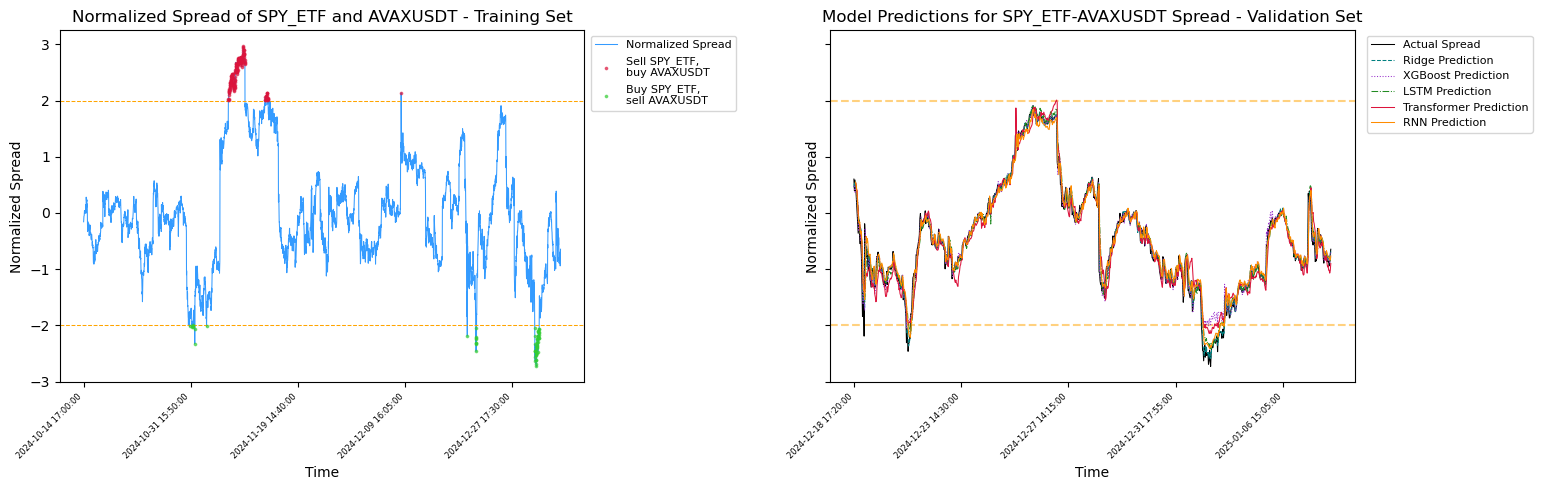

,SPY_ETF_EMA8,SPY_ETF_EMA21,SPY_ETF_EMA55,SPY_ETF_MACD,SPY_ETF_RSI14,SPY_ETF_BBupper,SPY_ETF_BBmiddle,SPY_ETF_BBlower,SPY_ETF_ATR14,SPY_ETF_StochK14,...,ETHUSDT_BBupper,ETHUSDT_BBmiddle,ETHUSDT_BBlower,ETHUSDT_ATR14,ETHUSDT_StochK14,ETHUSDT_StochD3,ETHUSDT_CCI20,ETHUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-14 17:00:00,-0.821943,-0.826815,-0.863946,0.095464,0.157968,-0.938772,-0.815009,-0.684807,-1.050478,-0.861277,...,-1.214199,-1.189273,-1.152963,-0.836899,-0.868914,-0.995396,-0.577529,-0.684591,1.205524,No action
2024-10-14 17:05:00,-0.817547,-0.824756,-0.861979,0.112251,0.604617,-0.937313,-0.814156,-0.684547,-1.002269,-0.544443,...,-1.216120,-1.190054,-1.152556,-0.823057,-0.612589,-0.839734,-0.041059,-0.140110,1.198483,No action
2024-10-14 17:10:00,-0.813803,-0.822750,-0.860030,0.125837,0.632310,-0.935771,-0.813230,-0.684224,-1.051632,0.315535,...,-1.217186,-1.190534,-1.152423,-0.866111,-0.324225,-0.623600,0.065176,-0.072814,1.197586,No action
2024-10-14 17:15:00,-0.807646,-0.819595,-0.857620,0.154405,0.901345,-0.932689,-0.812509,-0.685772,-1.036958,1.030674,...,-1.217698,-1.191029,-1.152896,-0.859142,-0.272297,-0.417576,-0.380903,-0.540824,1.204363,No action
2024-10-14 17:20:00,-0.802424,-0.816548,-0.855227,0.177393,0.936069,-0.928929,-0.811485,-0.687382,-1.081603,1.338456,...,-1.217873,-1.191235,-1.153133,-0.893167,-0.372838,-0.334785,-0.237298,-0.418468,1.202716,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.204e-01, tolerance: 4.444e-01
  model = cd_fast.enet_coordinate_descent(


[pypickle] Pickle file loaded: [models/base_ridge_SPY_ETF_ETHUSDT.pkl]
Loaded Ridge Regression model from models/base_ridge_SPY_ETF_ETHUSDT.pkl.
Ridge Regression MSE: 0.0007288895632812315
[pypickle] Pickle file loaded: [models/base_xgb_SPY_ETF_ETHUSDT.pkl]
Loaded XGBoost model from models/base_xgb_SPY_ETF_ETHUSDT.pkl.
XGBoost MSE: 0.0011523170832523056
[pypickle] Pickle file loaded: [models/base_lstm_SPY_ETF_ETHUSDT.pkl]
Loaded LSTM model from models/base_lstm_SPY_ETF_ETHUSDT.pkl.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
LSTM MSE: 0.002070406035353857
[pypickle] Pickle file loaded: [models/base_rnn_SPY_ETF_ETHUSDT.pkl]
Loaded RNN model from models/base_rnn_SPY_ETF_ETHUSDT.pkl.
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
RNN MSE: 0.0021244748484833707
[pypickle] Pickle file loaded: [models/base_transformer_SPY_ETF_ETHUSDT.pkl]
Loaded Transformer model from models/base_transformer_SPY_ETF_ETHUSDT.pkl
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Transformer MSE: 0.005631890233364166


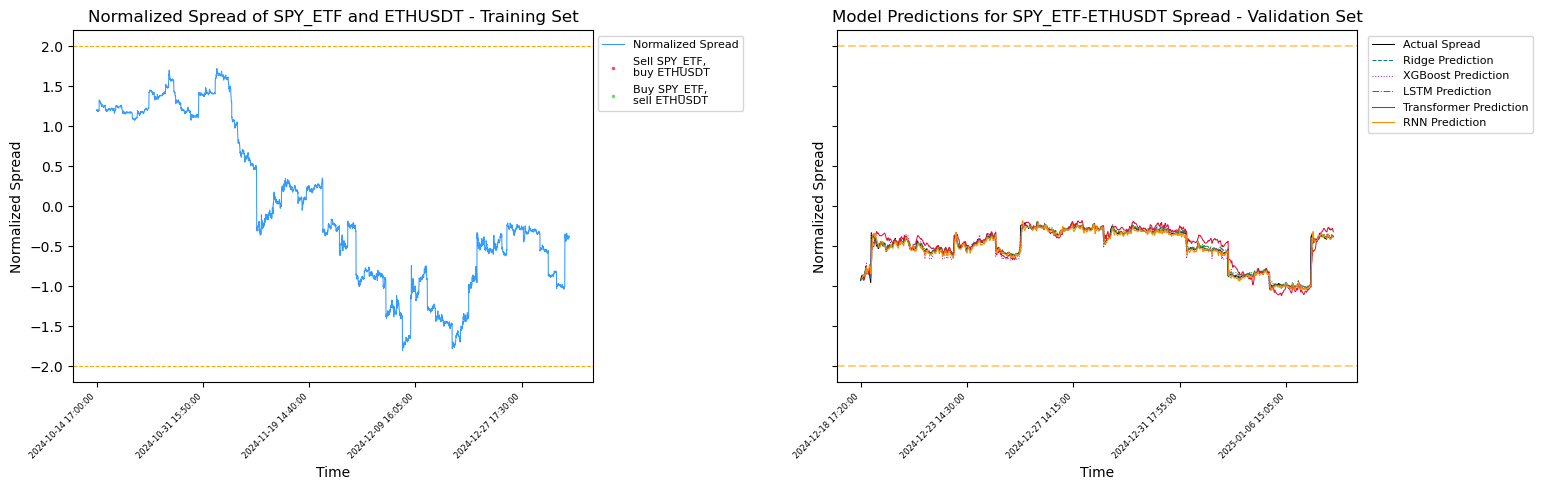

,EQQQ_ETF_EMA8,EQQQ_ETF_EMA21,EQQQ_ETF_EMA55,EQQQ_ETF_MACD,EQQQ_ETF_RSI14,EQQQ_ETF_BBupper,EQQQ_ETF_BBmiddle,EQQQ_ETF_BBlower,EQQQ_ETF_ATR14,EQQQ_ETF_StochK14,...,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,BNBUSDT_StochD3,BNBUSDT_CCI20,BNBUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-31 13:40:00,-2.421369,-2.359066,-2.286300,-0.917897,-0.882027,-2.234270,-2.324478,-2.382582,0.939460,-1.357598,...,-1.776531,-1.711959,-1.611875,-0.946220,0.903649,0.516372,0.882182,1.225796,-2.478167,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 13:45:00,-2.435985,-2.369627,-2.292054,-0.984888,-1.104786,-2.249224,-2.338676,-2.395838,0.958088,-1.439556,...,-1.771578,-1.710109,-1.613285,-0.963566,1.280202,0.924325,1.053383,1.225796,-2.518491,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 13:50:00,-2.447920,-2.379460,-2.297693,-1.031632,-1.119474,-2.265577,-2.352450,-2.406870,0.731855,-1.439556,...,-1.765701,-1.708064,-1.615262,-0.987518,1.318220,1.204598,1.125765,1.225796,-2.521504,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 14:00:00,-2.449639,-2.385311,-2.301920,-1.008951,-0.789030,-2.286321,-2.364401,-2.409943,0.736321,-1.335259,...,-1.762715,-1.706993,-1.616201,-1.009760,1.228360,1.316311,0.825610,0.975192,-2.485700,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 14:05:00,-2.448141,-2.389470,-2.305543,-0.962965,-0.668818,-2.319364,-2.377455,-2.403005,0.595508,-1.011599,...,-1.763332,-1.707285,-1.616150,-0.975496,0.891388,1.182545,0.239439,0.286030,-2.471432,"Buy EQQQ_ETF, sell BNBUSDT"


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.892e-01, tolerance: 2.646e-01
  model = cd_fast.enet_coordinate_descent(


[pypickle] Pickle file loaded: [models/base_ridge_EQQQ_ETF_BNBUSDT.pkl]
Loaded Ridge Regression model from models/base_ridge_EQQQ_ETF_BNBUSDT.pkl.
Ridge Regression MSE: 0.0005946804114386311
[pypickle] Pickle file loaded: [models/base_xgb_EQQQ_ETF_BNBUSDT.pkl]
Loaded XGBoost model from models/base_xgb_EQQQ_ETF_BNBUSDT.pkl.
XGBoost MSE: 0.005155259605027899
[pypickle] Pickle file loaded: [models/base_lstm_EQQQ_ETF_BNBUSDT.pkl]
Loaded LSTM model from models/base_lstm_EQQQ_ETF_BNBUSDT.pkl.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
LSTM MSE: 0.0037662119976667975
[pypickle] Pickle file loaded: [models/base_rnn_EQQQ_ETF_BNBUSDT.pkl]
Loaded RNN model from models/base_rnn_EQQQ_ETF_BNBUSDT.pkl.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
RNN MSE: 0.0030160621907182597
[pypickle] Pickle file loaded: [models/base_transformer_EQQQ_ETF_BNBUSDT.pkl]
Loaded Transformer model from models/base_transformer_EQQQ_ETF_BNBUSDT.pkl
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
Transformer MSE: 0.020153347345703964


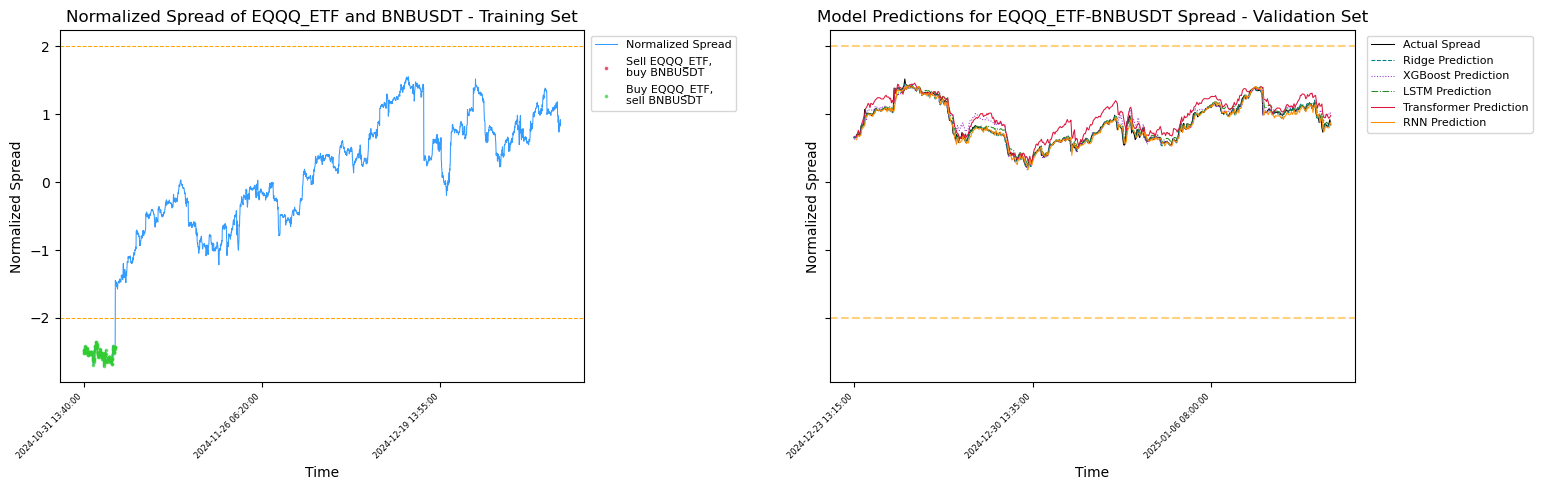

,BNBUSDT_EMA8,BNBUSDT_EMA21,BNBUSDT_EMA55,BNBUSDT_MACD,BNBUSDT_RSI14,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,...,ADAUSDT_BBupper,ADAUSDT_BBmiddle,ADAUSDT_BBlower,ADAUSDT_ATR14,ADAUSDT_StochK14,ADAUSDT_StochD3,ADAUSDT_CCI20,ADAUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-04 20:30:00,-1.549877,-1.556473,-1.542531,0.010369,1.327634,-1.575123,-1.565233,-1.551071,-0.859950,1.415713,...,-1.170352,-1.165995,-1.160889,-0.951622,1.308670,0.592696,1.456019,1.365633,-1.529669,No action
2024-10-04 20:35:00,-1.542836,-1.553019,-1.541699,0.125173,1.668612,-1.566268,-1.562052,-1.553735,-0.828814,1.415713,...,-1.169088,-1.165624,-1.161437,-0.936036,1.485379,1.187456,1.842159,1.365633,-1.519034,No action
2024-10-04 20:40:00,-1.536575,-1.549558,-1.540770,0.224898,1.773385,-1.558807,-1.558430,-1.554071,-0.854715,1.415713,...,-1.168000,-1.165159,-1.161615,-0.950474,1.485379,1.477211,1.640494,1.365633,-1.515485,No action
2024-10-04 20:45:00,-1.534060,-1.547376,-1.540254,0.265662,1.082272,-1.554550,-1.555868,-1.553260,-0.823952,1.233995,...,-1.167815,-1.164958,-1.161396,-0.910191,1.090238,1.401807,0.446487,0.275851,-1.526110,No action
2024-10-04 20:50:00,-1.532890,-1.545713,-1.539882,0.282772,0.869689,-1.551331,-1.553836,-1.552453,-0.850201,0.991706,...,-1.167767,-1.164865,-1.161257,-0.909955,0.553975,1.080281,0.018030,-0.113357,-1.529651,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+00, tolerance: 2.730e+00
  model = cd_fast.enet_coordinate_descent(


[pypickle] Pickle file loaded: [models/base_ridge_BNBUSDT_ADAUSDT.pkl]
Loaded Ridge Regression model from models/base_ridge_BNBUSDT_ADAUSDT.pkl.
Ridge Regression MSE: 0.00015980424284292162
[pypickle] Pickle file loaded: [models/base_xgb_BNBUSDT_ADAUSDT.pkl]
Loaded XGBoost model from models/base_xgb_BNBUSDT_ADAUSDT.pkl.
XGBoost MSE: 0.0003279232183944242
[pypickle] Pickle file loaded: [models/base_lstm_BNBUSDT_ADAUSDT.pkl]
Loaded LSTM model from models/base_lstm_BNBUSDT_ADAUSDT.pkl.
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
LSTM MSE: 0.0014658408851390158
[pypickle] Pickle file loaded: [models/base_rnn_BNBUSDT_ADAUSDT.pkl]
Loaded RNN model from models/base_rnn_BNBUSDT_ADAUSDT.pkl.
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
RNN MSE: 0.0007013725677559252
[pypickle] Pickle file loaded: [models/base_transformer_BNBUSDT_ADAUSDT.pkl]
Loaded Transformer model from models/base_transformer_BNBUSDT_ADAUSDT.pkl
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
Transformer MSE: 0.0009158155057328503

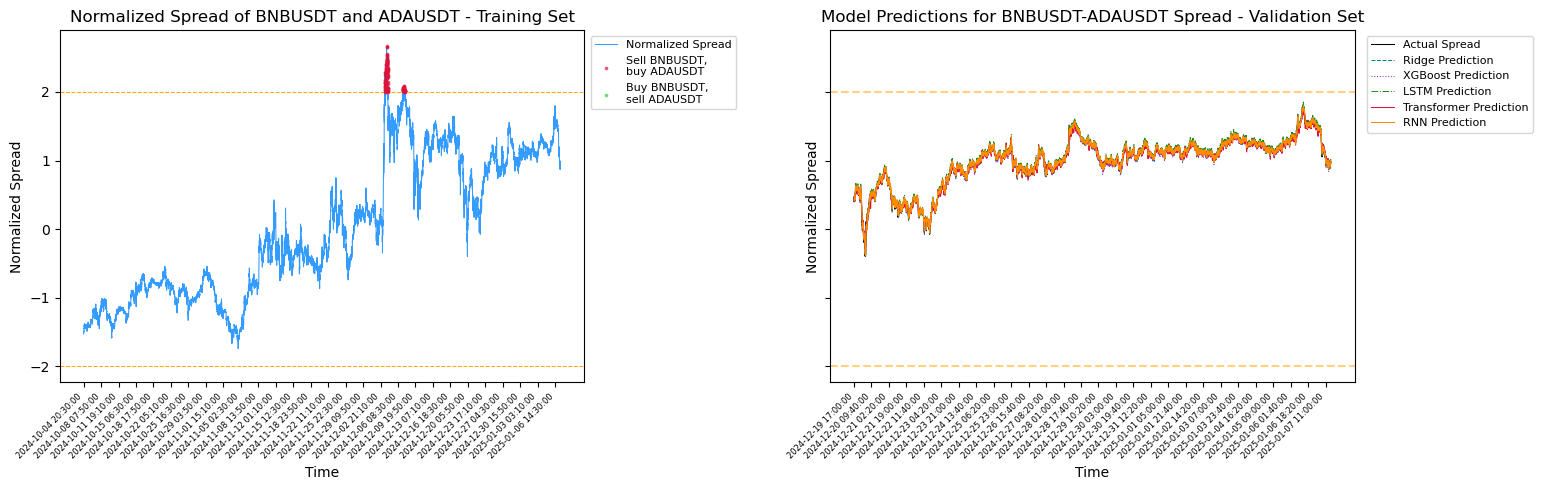

,BNBUSDT_EMA8,BNBUSDT_EMA21,BNBUSDT_EMA55,BNBUSDT_MACD,BNBUSDT_RSI14,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,...,BTCUSDT_BBupper,BTCUSDT_BBmiddle,BTCUSDT_BBlower,BTCUSDT_ATR14,BTCUSDT_StochK14,BTCUSDT_StochD3,BTCUSDT_CCI20,BTCUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-04 20:30:00,-1.549877,-1.556473,-1.542531,0.010369,1.327634,-1.575123,-1.565233,-1.551071,-0.859950,1.415713,...,-1.618731,-1.610621,-1.601708,-1.075696,1.104313,0.193947,0.955025,1.329005,1.606202,No action
2024-10-04 20:35:00,-1.542836,-1.553019,-1.541699,0.125173,1.668612,-1.566268,-1.562052,-1.553735,-0.828814,1.415713,...,-1.617758,-1.609975,-1.601395,-1.066323,1.440182,0.951930,1.340293,1.329005,1.603632,No action
2024-10-04 20:40:00,-1.536575,-1.549558,-1.540770,0.224898,1.773385,-1.558807,-1.558430,-1.554071,-0.854715,1.415713,...,-1.617209,-1.609234,-1.600459,-1.101918,1.440182,1.374378,1.315355,1.329005,1.603382,No action
2024-10-04 20:45:00,-1.534060,-1.547376,-1.540254,0.265662,1.082272,-1.554550,-1.555868,-1.553260,-0.823952,1.233995,...,-1.616920,-1.608707,-1.599692,-1.105290,1.290407,1.438567,0.859992,0.914392,1.605177,No action
2024-10-04 20:50:00,-1.532890,-1.545713,-1.539882,0.282772,0.869689,-1.551331,-1.553836,-1.552453,-0.850201,0.991706,...,-1.616693,-1.608364,-1.599232,-1.120546,1.043253,1.301656,0.554197,0.644823,1.606358,No action


[pypickle] Pickle file loaded: [models/base_ridge_BNBUSDT_BTCUSDT.pkl]
Loaded Ridge Regression model from models/base_ridge_BNBUSDT_BTCUSDT.pkl.
Ridge Regression MSE: 4.581584533145013e-05
[pypickle] Pickle file loaded: [models/base_xgb_BNBUSDT_BTCUSDT.pkl]
Loaded XGBoost model from models/base_xgb_BNBUSDT_BTCUSDT.pkl.
XGBoost MSE: 9.890036375907893e-05
[pypickle] Pickle file loaded: [models/base_lstm_BNBUSDT_BTCUSDT.pkl]
Loaded LSTM model from models/base_lstm_BNBUSDT_BTCUSDT.pkl.
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
LSTM MSE: 0.00019124791674634642
[pypickle] Pickle file loaded: [models/base_rnn_BNBUSDT_BTCUSDT.pkl]
Loaded RNN model from models/base_rnn_BNBUSDT_BTCUSDT.pkl.
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
RNN MSE: 0.00018735627043952672
[pypickle] Pickle file loaded: [models/base_transformer_BNBUSDT_BTCUSDT.pkl]
Loaded Transformer model from models/base_transformer_BNBUSDT_BTCUSDT.pkl
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
Transformer MSE: 0.000719767868500899

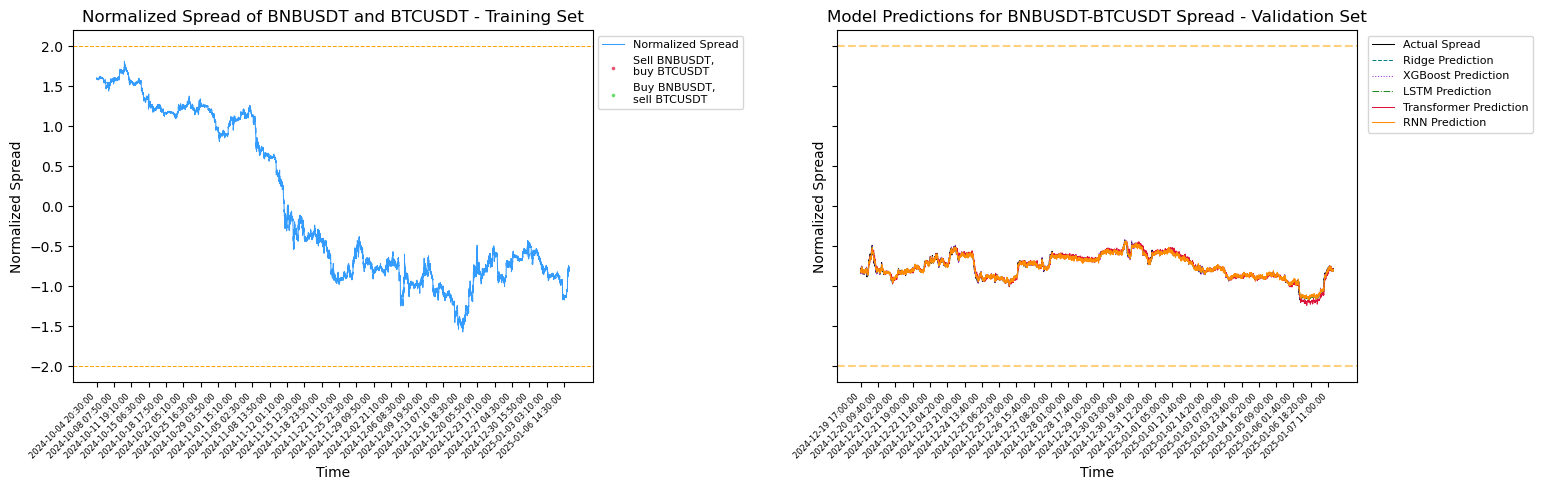

,BNBUSDT_EMA8,BNBUSDT_EMA21,BNBUSDT_EMA55,BNBUSDT_MACD,BNBUSDT_RSI14,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,...,TRXUSDT_BBupper,TRXUSDT_BBmiddle,TRXUSDT_BBlower,TRXUSDT_ATR14,TRXUSDT_StochK14,TRXUSDT_StochD3,TRXUSDT_CCI20,TRXUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-04 20:30:00,-1.549877,-1.556473,-1.542531,0.010369,1.327634,-1.575123,-1.565233,-1.551071,-0.859950,1.415713,...,-1.054722,-1.061994,-1.067222,-0.426393,-0.209515,-0.683981,-0.681322,-0.367330,-1.528881,No action
2024-10-04 20:35:00,-1.542836,-1.553019,-1.541699,0.125173,1.668612,-1.566268,-1.562052,-1.553735,-0.828814,1.415713,...,-1.054852,-1.062087,-1.067275,-0.423538,-0.015881,-0.283463,-0.152442,0.162034,-1.518278,No action
2024-10-04 20:40:00,-1.536575,-1.549558,-1.540770,0.224898,1.773385,-1.558807,-1.558430,-1.554071,-0.854715,1.415713,...,-1.055008,-1.062272,-1.067490,-0.420888,-0.209515,-0.149958,-0.623758,-0.367330,-1.514741,No action
2024-10-04 20:45:00,-1.534060,-1.547376,-1.540254,0.265662,1.082272,-1.554550,-1.555868,-1.553260,-0.823952,1.233995,...,-1.055034,-1.062364,-1.067652,-0.432816,-0.209515,-0.149958,-0.580148,-0.367330,-1.525346,No action
2024-10-04 20:50:00,-1.532890,-1.545713,-1.539882,0.282772,0.869689,-1.551331,-1.553836,-1.552453,-0.850201,0.991706,...,-1.055227,-1.062549,-1.067829,-0.443892,-0.306332,-0.250087,-0.525799,-0.102648,-1.528881,No action


[pypickle] Pickle file loaded: [models/base_ridge_BNBUSDT_TRXUSDT.pkl]
Loaded Ridge Regression model from models/base_ridge_BNBUSDT_TRXUSDT.pkl.
Ridge Regression MSE: 0.00015862503376715505
[pypickle] Pickle file loaded: [models/base_xgb_BNBUSDT_TRXUSDT.pkl]
Loaded XGBoost model from models/base_xgb_BNBUSDT_TRXUSDT.pkl.
XGBoost MSE: 0.00039124032073265983
[pypickle] Pickle file loaded: [models/base_lstm_BNBUSDT_TRXUSDT.pkl]
Loaded LSTM model from models/base_lstm_BNBUSDT_TRXUSDT.pkl.
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
LSTM MSE: 0.0012394132011519818
[pypickle] Pickle file loaded: [models/base_rnn_BNBUSDT_TRXUSDT.pkl]
Loaded RNN model from models/base_rnn_BNBUSDT_TRXUSDT.pkl.
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
RNN MSE: 0.0006684567057659514
[pypickle] Pickle file loaded: [models/base_transformer_BNBUSDT_TRXUSDT.pkl]
Loaded Transformer model from models/base_transformer_BNBUSDT_TRXUSDT.pkl
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
Transformer MSE: 0.002241643434470541

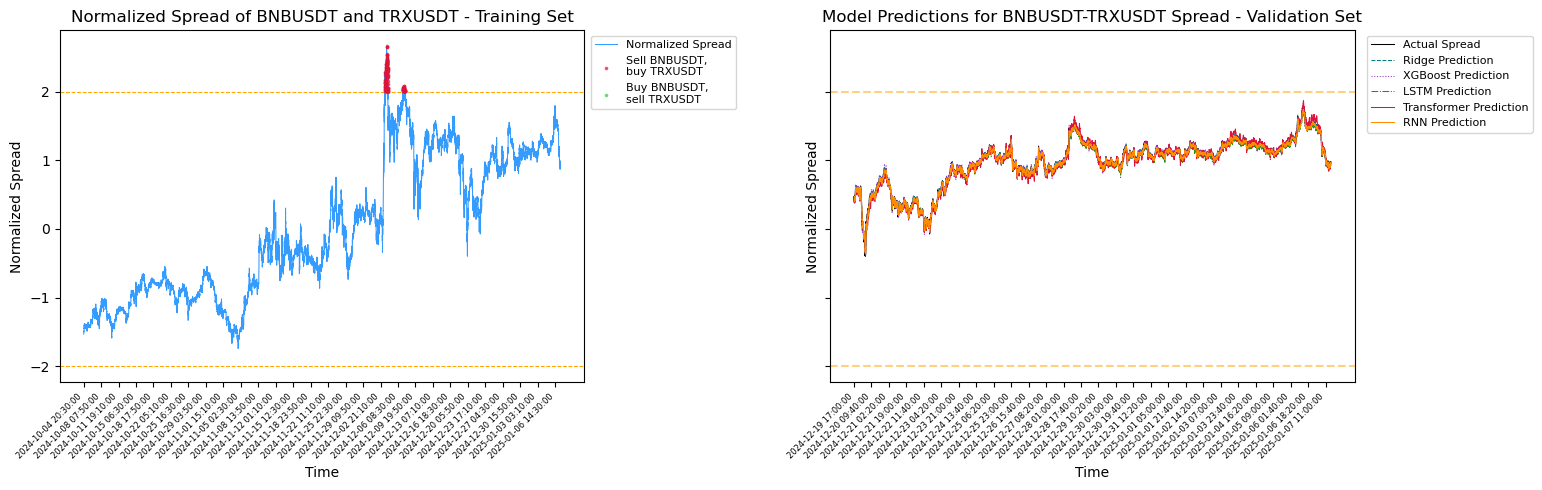

,BNBUSDT_EMA8,BNBUSDT_EMA21,BNBUSDT_EMA55,BNBUSDT_MACD,BNBUSDT_RSI14,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,...,XRPUSDT_BBupper,XRPUSDT_BBmiddle,XRPUSDT_BBlower,XRPUSDT_ATR14,XRPUSDT_StochK14,XRPUSDT_StochD3,XRPUSDT_CCI20,XRPUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-04 20:30:00,-1.549877,-1.556473,-1.542531,0.010369,1.327634,-1.575123,-1.565233,-1.551071,-0.859950,1.415713,...,-1.043663,-1.040717,-1.037247,-0.817933,0.972741,0.243749,0.908459,1.345288,-1.534199,No action
2024-10-04 20:35:00,-1.542836,-1.553019,-1.541699,0.125173,1.668612,-1.566268,-1.562052,-1.553735,-0.828814,1.415713,...,-1.043402,-1.040591,-1.037259,-0.819008,1.323922,0.898844,1.089337,1.345288,-1.523464,No action
2024-10-04 20:40:00,-1.536575,-1.549558,-1.540770,0.224898,1.773385,-1.558807,-1.558430,-1.554071,-0.854715,1.415713,...,-1.043172,-1.040482,-1.037275,-0.826779,1.464394,1.299180,0.969691,1.345288,-1.519884,No action
2024-10-04 20:45:00,-1.534060,-1.547376,-1.540254,0.265662,1.082272,-1.554550,-1.555868,-1.553260,-0.823952,1.233995,...,-1.043135,-1.040464,-1.037276,-0.822143,1.241614,1.392061,0.451953,0.731344,-1.530613,No action
2024-10-04 20:50:00,-1.532890,-1.545713,-1.539882,0.282772,0.869689,-1.551331,-1.553836,-1.552453,-0.850201,0.991706,...,-1.043173,-1.040488,-1.037286,-0.819532,0.827879,1.220705,0.044865,0.205105,-1.534183,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.078e+00, tolerance: 2.730e+00
  model = cd_fast.enet_coordinate_descent(


[pypickle] Pickle file loaded: [models/base_ridge_BNBUSDT_XRPUSDT.pkl]
Loaded Ridge Regression model from models/base_ridge_BNBUSDT_XRPUSDT.pkl.
Ridge Regression MSE: 0.00016669478239243684
[pypickle] Pickle file loaded: [models/base_xgb_BNBUSDT_XRPUSDT.pkl]
Loaded XGBoost model from models/base_xgb_BNBUSDT_XRPUSDT.pkl.
XGBoost MSE: 0.0003133097939807768
[pypickle] Pickle file loaded: [models/base_lstm_BNBUSDT_XRPUSDT.pkl]
Loaded LSTM model from models/base_lstm_BNBUSDT_XRPUSDT.pkl.
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
LSTM MSE: 0.002176037781151727
[pypickle] Pickle file loaded: [models/base_rnn_BNBUSDT_XRPUSDT.pkl]
Loaded RNN model from models/base_rnn_BNBUSDT_XRPUSDT.pkl.
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
RNN MSE: 0.0010359434745965674
[pypickle] Pickle file loaded: [models/base_transformer_BNBUSDT_XRPUSDT.pkl]
Loaded Transformer model from models/base_transformer_BNBUSDT_XRPUSDT.pkl
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
Transformer MSE: 0.0035733874067465834


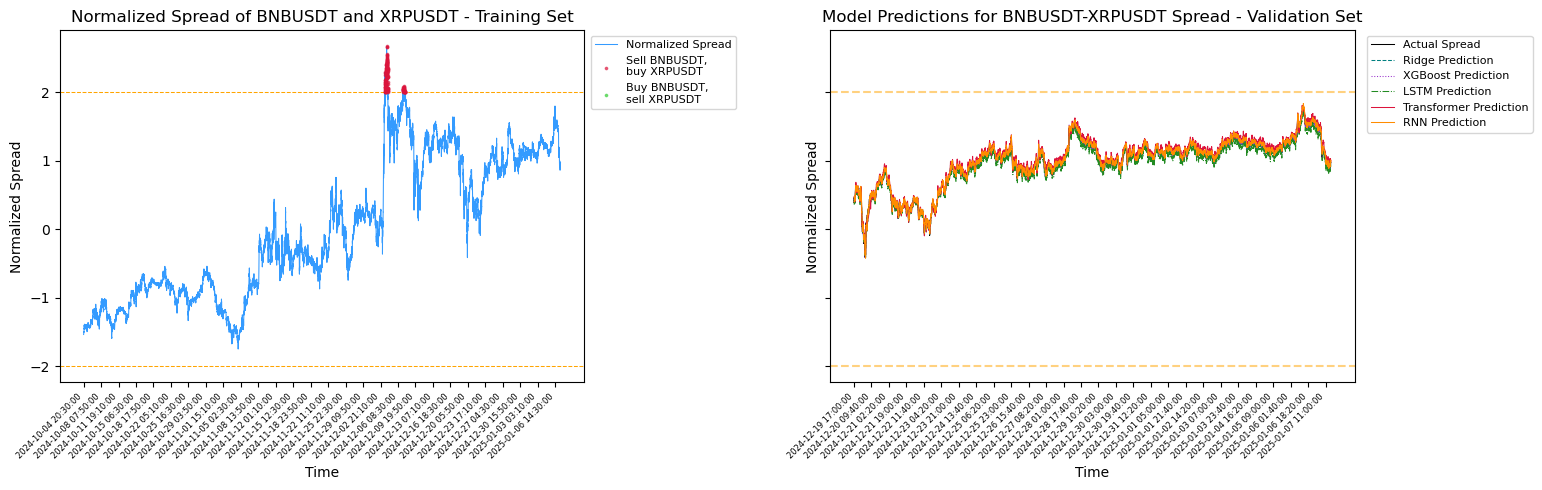

Pair,META DAXEX_ETF,AMZN BNBUSDT,AMZN TRXUSDT,SPY_ETF AVAXUSDT,SPY_ETF ETHUSDT,EQQQ_ETF BNBUSDT,BNBUSDT ADAUSDT,BNBUSDT BTCUSDT,BNBUSDT TRXUSDT,BNBUSDT XRPUSDT
Ridge MSE,0.002669,0.001170,0.000370,0.013739,0.000729,0.000595,0.000160,0.000046,0.000159,0.000167
Ridge Training Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ridge Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGB MSE,0.011973,0.001935,0.003790,0.026568,0.001152,0.005155,0.000328,0.000099,0.000391,0.000313
XGB Training Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGB Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LSTM MSE,0.029252,0.005185,0.003414,0.037718,0.002070,0.003766,0.001466,0.000191,0.001239,0.002176
LSTM Training Time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LSTM Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RNN MSE,0.027432,0.004466,0.003487,0.033556,0.002124,0.003016,0.000701,0.000187,0.000668,0.001036


In [5]:
# Ensure that we can overwrite the models
# Delete all files starting with "base_" in models folder
# base_files = glob.glob('models/base_*')
# for file in base_files:
#     try:
#         os.remove(file)
#     except Exception as e:
#         print(f'Error deleting {file}: {str(e)}')

untuned_performance = []
scalers = []
validation_dfs = pd.DataFrame()
s = 2.0

# Define configuration for Technical Analysis feature engineering
config = {
    'ema': [8, 21, 55],
    'macd': {
        'fast': 12,
        'slow': 26,
        'signal': 9,
    },
    'rsi': [14],
    'bb': {
        'timeperiod': 20,
        'nbdevup': 2,
        'nbdevdn': 2,
    },
    'atr': {
        'timeperiod': 14,
    },
    'stoch': {
        'fastk_period': 14,
        'slowk_period': 3,
        'slowd_period': 3,
    },
    'cci': {
        'timeperiod': 20,
    },
    'willr': {
        'timeperiod': 14,
    },
}

for p in pairs:
    tickerX, tickerY = p.split(' ')
    spread_df = create_features(tickerX, tickerY,
                                df_full[df_full['Symbol']==tickerX],
                                df_full[df_full['Symbol']==tickerY],
                                config=config,
                                dropna=True)
    spread_df, scaler = normalize_features(spread_df)
    spread_df = spread_df.rename(columns={'Spread':'NormalizedSpread'})
    # Save scaler for test set
    scalers.append({p:scaler})

    # ADD LASSO FEATURE SELECTION

    # Generate trading signals based on spreads
    spread_df.loc[:, 'TradingSignal'] = 'No action'
    spread_df.loc[spread_df['NormalizedSpread'] < -1*s, 'TradingSignal']= f'Buy {tickerX}, sell {tickerY}'
    spread_df.loc[spread_df['NormalizedSpread'] > s, 'TradingSignal'] = f'Buy {tickerY}, sell {tickerX}'

    # Preview the data
    display(spread_df.head())
    # Added .copy() to avoid warnings
    model_df = spread_df.drop(['TradingSignal'], axis=1).copy()

    # Create 5 lags
    # To be replaced with/extended by Technical Analysis features
    for lag in range(1, 6):
        model_df.loc[:, f'NormalizedSpread_Lag{lag}'] = model_df['NormalizedSpread'].shift(lag)
    model_df = model_df.dropna()

    # Perform LASSO feature selection
    X_temp = model_df.drop('NormalizedSpread', axis=1)
    y_temp = model_df['NormalizedSpread']
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_temp, y_temp)
    # Get selected features based on non-zero coefficients
    selected_features = X_temp.columns[abs(lasso.coef_) > 0].tolist()
    model_df = pd.concat([X_temp[selected_features], y_temp], axis=1)

    # Models with default parameters
    (ridge, ridge_mse, ridge_test_df,
     ridge_time, ridge_memory) = models.ridge_regression(df=model_df, p=p,
                                                         pickle_file=f'models/base_ridge_{tickerX}_{tickerY}.pkl')
    (xgb, xgb_mse, xgb_test_df,
     xgb_time, xgb_memory) = models.xgboost_regression(df=model_df, p=p,
                                                      pickle_file=f'models/base_xgb_{tickerX}_{tickerY}.pkl')
    (lstm, lstm_mse, lstm_test_df,
     lstm_time, lstm_memory) = models.lstm_regression(df=model_df, p=p,
                                                     pickle_file=f'models/base_lstm_{tickerX}_{tickerY}.pkl')
    (rnn, rnn_mse, rnn_test_df,
     rnn_time, rnn_memory) = models.rnn_regression(df=model_df, p=p,
                                                  pickle_file=f'models/base_rnn_{tickerX}_{tickerY}.pkl')
    (trf, trf_mse, trf_test_df,
     trf_time, trf_memory) = models.transformer_regression(df=model_df, p=p,
                                                          pickle_file=f'models/base_transformer_{tickerX}_{tickerY}.pkl')

    # Save the models
    # pypickle.save(f'models/base_ridge_{p.replace(" ", "_")}.pkl', ridge)
    # pypickle.save(f'models/base_xgb_{p.replace(" ", "_")}.pkl', xgb)
    # pypickle.save(f'models/base_lstm_{p.replace(" ", "_")}.pkl', lstm)
    # pypickle.save(f'models/base_rnn_{p.replace(" ", "_")}.pkl', rnn)
    # pypickle.save(f'models/base_transformer_{p.replace(" ", "_")}.pkl', trf)

    validation_dfs = pd.concat([validation_dfs,
                                ridge_test_df.reset_index(),
                                xgb_test_df.reset_index(),
                                lstm_test_df.reset_index(),
                                rnn_test_df.reset_index(),
                                trf_test_df.reset_index(),
                                ])

    untuned_performance.append({'Pair': p,
                                'Ridge MSE': ridge_mse,
                                'Ridge Training Time': ridge_time,
                                'Ridge Memory Usage': ridge_memory,
                                'XGB MSE': xgb_mse,
                                'XGB Training Time': xgb_time,
                                'XGB Memory Usage': xgb_memory,
                                'LSTM MSE': lstm_mse,
                                'LSTM Training Time': lstm_time,
                                'LSTM Memory Usage': lstm_memory,
                                'RNN MSE': rnn_mse,
                                'RNN Training Time': rnn_time,
                                'RNN Memory Usage': rnn_memory,
                                'Transformer MSE': trf_mse,
                                'Transformer Training Time': trf_time,
                                'Transformer Memory Usage': trf_memory,
                                })
    # Plot forecasts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    data.plot_spread(spread_df, tickerX, tickerY, ax=ax1)
    models.plot_model_forecasts(ridge_test_df, xgb_test_df,
                                lstm_test_df, trf_test_df,
                                rnn_test_df, tickerX, tickerY, ax=ax2)
    plt.show();
    # spread_df.to_csv(f'output/spread_{tickerX}_{tickerY}.csv')

untuned_performance_df = pd.DataFrame(untuned_performance).set_index('Pair').T
display(untuned_performance_df)

The above table shows the validation set metrics: MSE, time usage and memory usage.

The below listing shows the average metrics for the entire baseline pair trading portfolio.

In [6]:
display(untuned_performance_df.mean(axis=1))

Ridge MSE                    0.001980
Ridge Training Time          0.000000
Ridge Memory Usage           0.000000
XGB MSE                      0.005170
XGB Training Time            0.000000
XGB Memory Usage             0.000000
LSTM MSE                     0.008648
LSTM Training Time           0.000000
LSTM Memory Usage            0.000000
RNN MSE                      0.007667
RNN Training Time            0.000000
RNN Memory Usage             0.000000
Transformer MSE              0.016432
Transformer Training Time    0.000000
Transformer Memory Usage     0.000000
dtype: float64

In [27]:
import pandas as pd

class Strategy:
    '''
    Trading Strategy Class for long/short pair trading using forecast spreads.
    
    Assumptions:
      1) A trading signal is generated based on PredictedSignal:
         e.g. 'No action', 'Long SPY_ETF / Short AVAXUSDT', or 'Short SPY_ETF / Long AVAXUSDT'.
      2) A signal is confirmed only if it occurs at least m times consecutively (default m=1).
      3) At a confirmed signal, the strategy invests a maximum of 1000 USD per asset.
      4) Total exposure per asset cannot exceed 25% of the initial capital.
      5) If no reversal signal occurs, a position is force‐closed after 144 periods.
    
    Note: This version always uses NextOpen prices for both trade execution and closure,
          and the allowed instruments check has been removed.
    '''
    
    def __init__(self, initial_capital=10000, m_threshold=1, max_exposure=0.25,
                 max_trade_size=1000, close_threshold=144):
        self.initial_capital = initial_capital
        self.asset_max_exposure = max_exposure*self.initial_capital  
        self.m_threshold = m_threshold
        self.max_trade_size = max_trade_size
        self.close_threshold = close_threshold
        self.trade_history = []  # Record of all executed trades
        self.positions = {}      # Open positions, keyed by pair

    def execute_trade(self, pair, signal, open_time,
                      asset_A, asset_B, next_open_A, next_open_B):
        '''
        Execute a trade for the given pair using NextOpen prices.
        Trades 1000 USD worth of each asset.
        '''
        # Determine the trade direction from the signal.
        # Assumes signal is either 'Long A / Short B' or 'Short A / Long B'
        if 'Long' in signal and 'Short' in signal:
            if signal.strip().split()[0] == 'Long':
                direction = 'Long A / Short B'
            else:
                direction = 'Short A / Long B'
        else:
            return  # Invalid signal
        
        # Use the NextOpen prices provided.
        price_A = next_open_A
        price_B = next_open_B
        
        # Calculate the quantity for each asset.
        qty_A = self.max_trade_size/price_A
        qty_B = self.max_trade_size/price_B
        
        # Check current exposure (based on open trades) for each asset.
        exposure_A = sum(trade['trade_size']
                         for trade in self.trade_history 
                         if (trade.get('asset_A') == asset_A) \
                             & (not trade.get('closed', False)))
        exposure_B = sum(trade['trade_size']
                         for trade in self.trade_history 
                         if (trade.get('asset_B') == asset_B)\
                         & (not trade.get('closed', False)))
        
        if ((exposure_A+self.max_trade_size > self.asset_max_exposure) |
           (exposure_B+self.max_trade_size > self.asset_max_exposure)):
            return  # Skip trade if exposure limits would be exceeded

        # Record the trade
        trade_record = {
            'pair': pair,
            'signal': signal,
            'open_time': open_time,
            'asset_A': asset_A,
            'asset_B': asset_B,
            'price_A': price_A,
            'price_B': price_B,
            'trade_size': self.max_trade_size,
            'direction': direction,
            'closed': False
        }
        self.trade_history.append(trade_record)
        
        # Open a new position
        self.positions[pair] = {
            'entry_time': open_time,
            'asset_A': asset_A,
            'asset_B': asset_B,
            'direction': direction,
            'entry_price_A': price_A,
            'entry_price_B': price_B,
            'quantity_A': qty_A,
            'quantity_B': qty_B,
            'age': 0
        }
        
    def close_trade(self, pair, close_time, asset_A, asset_B,
                    next_open_A, next_open_B):
        '''
        Close an open position for the given pair using NextOpen prices.
        '''
        if pair not in self.positions:
            return
        
        pos = self.positions.pop(pair)
        price_A = next_open_A
        price_B = next_open_B
        
        # Calculate P&L based on the trade direction
        if pos['direction'] == 'Long A / Short B':
            pnl_A = (price_A-pos['entry_price_A'])*pos['quantity_A']
            pnl_B = (pos['entry_price_B']-price_B)*pos['quantity_B']
        else:  # 'Short A / Long B'
            pnl_A = (pos['entry_price_A']-price_A)*pos['quantity_A']
            pnl_B = (price_B-pos['entry_price_B'])*pos['quantity_B']
        total_pnl = pnl_A+pnl_B
        self.initial_capital += total_pnl
        
        # Update trade history to mark trades as closed
        for trade in self.trade_history:
            if (trade['pair'] == pair) & (not trade.get('closed', False)):
                trade.update({
                    'close_time': close_time,
                    'close_price_A': price_A,
                    'close_price_B': price_B,
                    'pnl': total_pnl,
                    'closed': True
                })
                
    def run_strategy(self, df):
        '''
        Executes the trading strategy over a dataframe of signals.
        
        The dataframe is expected to have the following columns:
          - OpenTime (timestamp)
          - Pair (e.g. 'AMZN BNBUSDT')
          - NormalizedSpread
          - PredictedSpread
          - PredictedSignal (e.g. 'No action', 'Long SPY_ETF / Short AVAXUSDT', etc.)
          - AssetA
          - AssetB
          - NextOpenA
          - NextOpenB
          
        Prices from NextOpenA and NextOpenB are always used.
        '''
        df['OpenTime'] = pd.to_datetime(df['OpenTime'])
        df = df.sort_values(by=['Pair', 'OpenTime'])
        
        # Dictionary to count consecutive signals per pair
        signal_counters = {pair: 0 for pair in df['Pair'].unique()}
        
        for _, row in df.iterrows():
            pair = row['Pair']
            signal = row['PredictedSignal']
            open_time = row['OpenTime']
            asset_A = row['AssetA']
            asset_B = row['AssetB']
            next_open_A = row['NextOpenA']
            next_open_B = row['NextOpenB']
            
            position_open = pair in self.positions
            
            # Increment counter if signal is not "No action", otherwise reset
            if signal != 'No action':
                signal_counters[pair] += 1
            else:
                signal_counters[pair] = 0
            
            # Once a signal is confirmed over m consecutive periods, execute logic
            if signal_counters[pair] >= self.m_threshold:
                if not position_open:
                    self.execute_trade(pair, signal, open_time, asset_A, asset_B, next_open_A, next_open_B)
                else:
                    current_pos = self.positions[pair]
                    reversal = False
                    # Determine reversal based on the new signal and current position.
                    if (current_pos['direction'] == 'Long A / Short B') & ('Short' in signal):
                        reversal = True
                    elif (current_pos['direction'] == 'Short A / Long B') & ('Long' in signal):
                        reversal = True
                    if reversal:
                        self.close_trade(pair, open_time, asset_A, asset_B, next_open_A, next_open_B)
                        self.execute_trade(pair, signal, open_time, asset_A, asset_B, next_open_A, next_open_B)
                # Reset counter after executing a trade
                signal_counters[pair] = 0
            
            # For any open position, increment its age
            # and force-close if it reaches the threshold
            if pair in self.positions:
                self.positions[pair]['age'] += 1
                if self.positions[pair]['age'] >= self.close_threshold:
                    self.close_trade(pair, open_time, asset_A, asset_B, next_open_A, next_open_B)
        performance_metrics = {}
        closed_trades = [trade for trade in self.trade_history if trade.get('closed', False)]
        if closed_trades:
            # Sort closed trades by close_time
            closed_trades = sorted(closed_trades, key=lambda x: pd.to_datetime(x['close_time']))
            # Use the open_time of the first trade and close_time of the last trade for total duration
            start_time = pd.to_datetime(closed_trades[0]['open_time'])
            end_time = pd.to_datetime(closed_trades[-1]['close_time'])
            t_years = (end_time - start_time).days / 365.25
            if t_years <= 0:
                t_years = None

            # Construct portfolio value series based on closed trades.
            # Start with initial capital and add each trade's pnl cumulatively.
            portfolio_values = [self.initial_capital]
            for trade in closed_trades:
                portfolio_values.append(portfolio_values[-1] + trade['pnl'])
            # Calculate discrete returns from portfolio values
            portfolio_values = np.array(portfolio_values)
            returns = np.diff(portfolio_values) / portfolio_values[:-1]
            
            # Total return over the period
            total_return = portfolio_values[-1] / self.initial_capital - 1
            # Annualized return (if t_years is available)
            annual_ret = pp.annualized_return(self.initial_capital, portfolio_values[-1], t_years) if t_years else None
            # Sharpe Ratio (assuming a risk-free rate of 0)
            sharpe = pp.sharpe_ratio(returns, 0)
            # Sortino Ratio (risk-free rate 0)
            sortino = pp.sortino_ratio(returns, 0)
            # Hit Ratio: proportion of positive return periods
            hit = pp.hit_ratio(returns)
            # Maximum Drawdown based on the portfolio values time series
            max_dd = pp.max_drawdown(portfolio_values)
            # Portfolio volatility (standard deviation of returns)
            vol = pp.portfolio_volatility(returns)
            
            performance_metrics = {
                'Total Return': total_return,
                'Annualized Return': annual_ret,
                'Sharpe Ratio': sharpe,
                'Sortino Ratio': sortino,
                'Hit Ratio': hit,
                'Max Drawdown': max_dd,
                'Portfolio Volatility': vol
            }
        else:
            performance_metrics = {
                'Total Return': 'Not available',
                'Annualized Return': 'Not available',
                'Sharpe Ratio': 'Not available',
                'Sortino Ratio': 'Not available',
                'Hit Ratio': 'Not available',
                'Max Drawdown': 'Not available',
                'Portfolio Volatility': 'Not available',
            }
        self.performance_df = pd.DataFrame(list(performance_metrics.items()),
                                           columns=['Metric', 'Value'])
        return {
            'Final Portfolio Value': self.initial_capital,
            'Trades Executed': self.trade_history,
            'Performance Metrics': self.performance_df
        }

## Validate the Base Models Strategy

We run the strategy on the validation set and obtain model performance metrics.

In [62]:
validation_dfs = validation_dfs.reset_index(drop=True)

# Create a column with Next Opening Price for trading strategy execution
df_temp = (df_full
           .groupby(by=['Symbol', 'OpenTime'])
           .agg({'Open': 'first',
                 'Close': 'first'})
           .reset_index())
df_temp['OpenTime'] = pd.to_datetime(df_temp['OpenTime'])
df_temp = df_temp.sort_values(by=['Symbol', 'OpenTime'])
df_temp = (df_temp
           .groupby(by=['Symbol'], group_keys=False)
           # Shift open prices within each symbol
           .apply(lambda x: x.assign(NextOpen=x['Open'].shift(1)))
           .reset_index(level=0, drop=True))
performances = {}

for model in validation_dfs['Model'].unique().tolist():
    # Prepare dataframe for model-based strategy testing
    model_df = (validation_dfs[validation_dfs['Model']==model]
                .sort_index()
                .sort_values(by='Pair')
                [['OpenTime',
                  'Pair',
                  'NormalizedSpread',
                  'PredictedSpread',
                  'PredictedSignal']])
    model_df['OpenTime'] = pd.to_datetime(model_df['OpenTime'])
    model_df[['AssetA', 'AssetB']] = model_df['Pair'].str.split(' ', n=1, expand=True)
    model_df = (pd.merge(left=model_df,
                         right=df_temp[['OpenTime', 'Symbol', 'NextOpen', 'Close']],
                         left_on=['OpenTime', 'AssetA'],
                         right_on=['OpenTime', 'Symbol'],
                         how='left')
                .drop(['Symbol'], axis=1))
    model_df = model_df.rename(columns={'NextOpen':'NextOpenA',
                                        'Close':'CloseA'})
    model_df = (pd.merge(left=model_df,
                         right=df_temp[['OpenTime', 'Symbol', 'NextOpen', 'Close']],
                         left_on=['OpenTime', 'AssetB'],
                         right_on=['OpenTime', 'Symbol'],
                         how='left')
                .drop(['Symbol'], axis=1))
    model_df = model_df.rename(columns={'NextOpen':'NextOpenB',
                                        'Close':'CloseB'})
    # Test the strategy
    strategy_baseline = Strategy()
    performance = strategy_baseline.run_strategy(model_df)
    performances[model] = performance
    log.info(f'Portfolio metrics for model {model} calculated correctly.')

metrics_list = []

for model, perf in performances.items():
    if 'Performance Metrics' in perf and isinstance(perf['Performance Metrics'], pd.DataFrame):
        df_metrics = perf['Performance Metrics'].copy()
        df_metrics['Model'] = model
        metrics_list.append(df_metrics)

performance_df = pd.concat(metrics_list, ignore_index=True)
performance_df = performance_df[['Model', 'Metric', 'Value']]
performance_df = pd.pivot_table(performance_df,
                                index='Metric',
                                columns='Model',
                                values='Value')
display(performance_df)

Model,LSTM,RNN,Ridge Regression,Transformer,XGBoost
Metric,,,,,
Annualized Return,-0.118844,-0.115345,-0.117587,-0.405662,-0.123722
Hit Ratio,0.526316,0.512821,0.450980,0.545455,0.400000
Max Drawdown,0.010591,0.010585,0.010292,0.014144,0.009124
Portfolio Volatility,0.001585,0.001563,0.001041,0.002274,0.004175
Sharpe Ratio,-0.096971,-0.092816,-0.109149,-0.283495,-0.292198
Sortino Ratio,-0.078002,-0.075537,-0.107416,-0.206758,-0.291224
Total Return,-0.005871,-0.005688,-0.005805,-0.014144,-0.006128


# Hyperparameter Tuning

In this subsection we describe which hyperparameters of the analyzed models we have tuned and conclude the technical part of the research. We also test different thresholds for trading signals and the impact on the trading strategy result.

The baseline models for each trading pair were trained on the same sets of hyperparameters, as listed below:
- Ridge Regression: =1.0, solver=“auto”
- XGBoost: learning rate=0.1, estimators=100, max depth=3
- RNN: lookback=10, units=50, dropout rate=0.2, learning rate=0.001, epochs=50, batch size=32
- LSTM: lookback=10, units=50, dropout rate=0.2, learning rate=0.001, epochs=50, batch size=32
- Transformer: lookback=10, number of attention heads=2, feed-forward dimension=64, dropout rate=0.1, learning rate=0.001, epochs=50, batch size=32.
